In [1]:
import argparse
import math
import os
from heapq import heappush, heappop, heappushpop

import matplotlib.pyplot as plotter
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import Image 
from IPython.display import Markdown as md
from tqdm import tqdm
import re
from collections import defaultdict

from utils.ens import *

In [2]:
pd.set_option("display.width", 180)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Utils

In [3]:
def average(data, weights=None):
    N = data.shape[1]
    if weights is None:
        weights = [1/N] * N
    elif np.sum(weights) != 1.:
        weights = weights / np.sum(weights)
    
    # Compute weighted avg
    return data.apply(lambda row: row.multiply(weights).sum(), axis=1)

In [4]:
def acc_from_roc(labels, probas, splits=None):
    '''Determines the greatest achievable accuracy from the ROC curve.'''
    if splits is None:
        splits = (250, 250)

    fpr, tpr, thresholds = roc_curve(labels, probas)
    tp = tpr * splits[0]
    tn = (1 - fpr) * splits[1]
    acc = (tp + tn) / np.sum(splits)
    best_threshold = thresholds[np.argmax(acc)]

    return np.amax(acc), best_threshold

## Load Data

In [10]:
paths = ['./data/csvs/v3/98']
gt_path = './data/features/annotations/gt'

In [11]:
# Ground truth
gt_dev = pd.read_json(os.path.join(gt_path, 'dev_all.jsonl'), lines=True)
gt_ts = pd.read_json(os.path.join(gt_path, 'test_seen.jsonl'), lines=True)
gt_tu = pd.read_json(os.path.join(gt_path, 'test_unseen.jsonl'), lines=True)
dev_or = {'Correct': gt_dev}

dev, ts, tu = {}, {}, {}
experiments = []
#print('Loading data:')
for path in paths:
    for csv in sorted(os.listdir(path)):
        if ".csv" in csv and "test_unseen" in csv:
            experiments.append(csv.split('_')[0])
    for exp in tqdm(experiments):
        dev[exp] = pd.read_csv(os.path.join(path, f'{exp}_dev_all.csv'))
        dev_idx = dev[exp].id.values
        tu[exp] = pd.read_csv(os.path.join(path, f'{exp}_test_unseen.csv'))
        tu_idx = tu[exp].id.values
        ts[exp] = pd.read_csv(os.path.join(path, f'{exp}_test_seen.csv'))
        ts_idx = ts[exp].id.values

dev_or.update(dev)
dev_probas = pd.DataFrame({k: v.proba.values for k, v in dev.items()})
ts_probas = pd.DataFrame({k: v.proba.values for k, v in ts.items()})
tu_probas = pd.DataFrame({k: v.proba.values for k, v in tu.items()})

100%|██████████| 120/120 [00:02<00:00, 58.96it/s]


In [9]:
experiments

['U1', 'U1a', 'U1ac', 'U1c', 'U5', 'U5a', 'U5c']

## Display Scores

### Dev

In [13]:
scores = {}
for exp in dev_probas.keys():
    scores[exp]=roc_auc_score(gt_dev.label, dev_probas[exp])
    
out = '| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |\n'
out += '| --- | --- | --- | --- | --- | --- | --- | --- |\n'
for model in ['U', 'O', 'D', 'X']:   
    for flag in ['', 'a', 'c', 'ac']:
        row = [f'{scores.get(f"{model}{num}{flag}")}' for num in [1, 5, 10, 15, 20, 36, 50, 72]]
        out += f'{" | ".join(row)} |\n'
md(out)

| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |
| --- | --- | --- | --- | --- | --- | --- | --- |
0.7353586550050993 | 0.746628756271183 | 0.7729806018275283 | 0.7632248560332128 | 0.7799909344706453 | 0.7716001689485017 | 0.7839880087770807 | 0.7776678925734771 |
0.7224093704607968 | 0.7418899568357182 | 0.7721049541057575 | 0.7739798704041372 | 0.7777915134283154 | 0.7795994684303242 | 0.7766892274726745 | 0.776648020521062 |
0.7225020861019253 | 0.7620195526985403 | 0.7790689289283103 | 0.7691998640170598 | 0.7614838623275747 | 0.7659960235291694 | 0.7738768530251053 | None |
0.7070700827229554 | 0.755405836964696 | 0.7763389683839664 | 0.761859875761041 | 0.7690916957690763 | 0.7772970300089626 | 0.7804081548557241 | None |
0.6915968723923726 | 0.76065972329532 | 0.767530982476744 | 0.7671189129606165 | 0.7616486901340256 | 0.7598870929525812 | 0.7595677390775823 | 0.7534485067630908 |
0.6891450587714147 | 0.764296236775144 | 0.7599592051179035 | 0.772681851428336 | 0.7663565843557809 | 0.7649143410493351 | 0.7631733473436969 | 0.7568480802711417 |
0.6887947996827065 | 0.7651512810211083 | 0.7703845638759258 | 0.765522143585623 | 0.7654912383719134 | 0.7627406743517632 | 0.7607833441501581 | None |
0.6832627664286965 | 0.7548804483316336 | 0.7566523472509813 | 0.7615868797066065 | 0.7734441800331716 | 0.7721667645331767 | 0.7706936160130216 | None |
0.6643796808521597 | 0.7191540212833905 | 0.7409112917349157 | 0.7428068115091014 | 0.742889225412327 | 0.7384697798518609 | 0.7424101945998289 | 0.7501210454203624 |
0.6750522813198586 | 0.7187110465535536 | 0.7488539316582707 | 0.74338370883168 | 0.736677277456707 | 0.7346581368276828 | 0.7459797467832823 | 0.7507494514324566 |
0.6741972370738943 | 0.7239031224567585 | 0.7536648432590577 | 0.7360488714446127 | 0.742549268061522 | 0.7534588085009941 | 0.7468605453740047 | None |
0.6557159192755818 | 0.7322835862409989 | 0.7354616723841313 | 0.7358222332107427 | 0.7388921511058916 | 0.7602785589929022 | 0.7456706946461868 | None |
0.6152918997434866 | 0.6733524945658332 | 0.6928124774649483 | 0.687903699354081 | 0.6985350928701672 | 0.6911435959246325 | 0.692487972720998 | 0.6989111063036335 |
0.6199482852757259 | 0.6819441439770889 | 0.6864357017028773 | 0.6894592617774618 | 0.709233447682624 | 0.693435732608091 | 0.6989059554346819 | 0.7119273521443067 |
0.6166414274088039 | 0.6754746525738892 | 0.6745217418178446 | 0.6854570366020747 | 0.6854467348641716 | 0.6943525872814744 | 0.6964644435516272 | None |
0.6191138445055681 | 0.6724871485819658 | 0.6907830350980211 | 0.6981384759608946 | 0.6958514901463877 | 0.687991264126258 | 0.7002245778862894 | None |


### Test Seen

In [14]:
scores = {}
for exp in ts_probas.keys():
    scores[exp]=roc_auc_score(gt_ts.label, ts_probas[exp])
    
out = '| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |\n'
out += '| --- | --- | --- | --- | --- | --- | --- | --- |\n'
for model in ['U', 'O', 'D', 'X']:   
    for flag in ['', 'a', 'c', 'ac']:
        row = [f'{scores.get(f"{model}{num}{flag}")}' for num in [1, 5, 10, 15, 20, 36, 50, 72]]
        out += f'{" | ".join(row)} |\n'
md(out)

| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |
| --- | --- | --- | --- | --- | --- | --- | --- |
0.7104081632653061 | 0.77827931172469 | 0.7790496198479393 | 0.7786294517807122 | 0.786658663465386 | 0.788765506202481 | 0.789735894357743 | 0.7804381752701081 |
0.7205262104841936 | 0.7649159663865547 | 0.789233693477391 | 0.7883493397358944 | 0.7784813925570228 | 0.7965646258503402 | 0.7864925970388157 | 0.7835194077631052 |
0.7334173669467787 | 0.7685394157663065 | 0.7881572629051621 | 0.7855682272909164 | 0.7865246098439376 | 0.794673869547819 | 0.8000440176070428 | None |
0.7350980392156863 | 0.7716426570628252 | 0.7851780712284913 | 0.7797198879551821 | 0.7890436174469788 | 0.7844637855142057 | 0.8023449379751901 | None |
0.7114285714285715 | 0.7720328131252501 | 0.7802921168467387 | 0.7795918367346939 | 0.7738175270108044 | 0.7739655862344939 | 0.7935214085634255 | 0.7866306522609043 |
0.7112525010004003 | 0.7712645058023208 | 0.7828091236494598 | 0.7844657863145258 | 0.7876750700280112 | 0.7887875150060024 | 0.7857022809123648 | 0.7867306922769108 |
0.7114565826330532 | 0.783421368547419 | 0.7802200880352141 | 0.7914205682272908 | 0.7883993597438975 | 0.7745818327330932 | 0.7895698279311725 | None |
0.71328131252501 | 0.7718327330932373 | 0.7797318927571029 | 0.787591036414566 | 0.7923449379751901 | 0.7844697879151661 | 0.7850700280112045 | None |
0.7033133253301321 | 0.73374949979992 | 0.7522729091636653 | 0.7594797919167667 | 0.7516646658663465 | 0.7589435774309724 | 0.7548399359743897 | 0.766326530612245 |
0.6969707883153262 | 0.7222368947579032 | 0.7504501800720289 | 0.7468827531012405 | 0.7442256902761104 | 0.7283953581432573 | 0.7500900360144058 | 0.7633393357342937 |
0.7135374149659863 | 0.7364825930372149 | 0.7583353341336535 | 0.743327330932373 | 0.7619687875150061 | 0.7737414965986396 | 0.7618727490996398 | None |
0.7053061224489796 | 0.7533973589435774 | 0.7567126850740296 | 0.758953581432573 | 0.7663325330132054 | 0.7708983593437375 | 0.7702701080432174 | None |
0.6631532613045218 | 0.6960224089635855 | 0.7222468987595037 | 0.706812725090036 | 0.7293797519007603 | 0.7236694677871148 | 0.7193417366946779 | 0.7278651460584233 |
0.6535894357743098 | 0.6923889555822329 | 0.7283473389355744 | 0.7136534613845538 | 0.7273049219687875 | 0.7229331732693076 | 0.7205522208883554 | 0.7276350540216086 |
0.6564705882352941 | 0.7026490596238495 | 0.7190896358543417 | 0.725876350540216 | 0.7271628651460584 | 0.7305582232893157 | 0.7314445778311325 | None |
0.6538735494197678 | 0.7129231692677072 | 0.7424029611844737 | 0.7239495798319328 | 0.725390156062425 | 0.7306462585034013 | 0.7350980392156863 | None |


### Test Unseen

In [15]:
scores = {}
for exp in tu_probas.keys():
    scores[exp]=roc_auc_score(gt_tu.label, tu_probas[exp])
    
out = '| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |\n'
out += '| --- | --- | --- | --- | --- | --- | --- | --- |\n'
for model in ['U', 'O', 'D', 'X']:   
    for flag in ['', 'a', 'c', 'ac']:
        row = [f'{scores.get(f"{model}{num}{flag}")}' for num in [1, 5, 10, 15, 20, 36, 50, 72]]
        out += f'{" | ".join(row)} |\n'
md(out)

| 1 | 5 | 10 | 15 | 20 | 36 | 50 | 72 |
| --- | --- | --- | --- | --- | --- | --- | --- |
0.7177216 | 0.7861466666666668 | 0.7875551999999999 | 0.7831941333333333 | 0.7751578666666666 | 0.7860672000000001 | 0.7840949333333334 | 0.7804405333333332 |
0.7100405333333333 | 0.7600405333333333 | 0.7750288000000001 | 0.7825877333333333 | 0.7753989333333333 | 0.7840885333333334 | 0.7830976000000001 | 0.7703653333333335 |
0.7203957333333333 | 0.7811786666666667 | 0.7770122666666667 | 0.7855487999999999 | 0.7779621333333333 | 0.7988416000000002 | 0.7773802666666666 | None |
0.7136133333333334 | 0.7727258666666666 | 0.7852890666666665 | 0.7707408 | 0.7874037333333334 | 0.7844656 | 0.7965872 | None |
0.6855050666666667 | 0.7621760000000001 | 0.7647888 | 0.7697674666666667 | 0.7585018666666665 | 0.7719018666666668 | 0.7824944 | 0.7697711999999999 |
0.6776202666666667 | 0.7495423999999999 | 0.7638976000000001 | 0.7730965333333334 | 0.7725194666666666 | 0.7766976 | 0.7749077333333333 | 0.7858208000000001 |
0.6871637333333334 | 0.7584309333333332 | 0.7628810666666667 | 0.7763605333333334 | 0.7764896 | 0.7749008000000001 | 0.7766186666666667 | None |
0.6754325333333333 | 0.7523274666666667 | 0.7635392000000001 | 0.7747215999999999 | 0.7788618666666668 | 0.7789178666666667 | 0.7757344 | None |
0.6858133333333333 | 0.7220597333333334 | 0.7341157333333332 | 0.7516069333333334 | 0.7495152 | 0.7648927999999999 | 0.7522501333333333 | 0.7588463999999999 |
0.6761770666666667 | 0.7146405333333333 | 0.7371354666666667 | 0.7373008000000001 | 0.7391285333333333 | 0.7322005333333333 | 0.7472672 | 0.7564768 |
0.6842661333333334 | 0.7263776 | 0.7494207999999999 | 0.7425312 | 0.7565370666666666 | 0.7717813333333333 | 0.7418165333333333 | None |
0.6738410666666667 | 0.7409850666666666 | 0.7458250666666666 | 0.7459936 | 0.7484325333333334 | 0.7598256 | 0.7605466666666667 | None |
0.6497109333333334 | 0.6980096 | 0.7135232 | 0.7088986666666667 | 0.7152453333333333 | 0.7095013333333333 | 0.7141141333333333 | 0.7177584 |
0.6424714666666667 | 0.6989525333333333 | 0.7162544000000001 | 0.7147002666666666 | 0.7194634666666666 | 0.7268229333333334 | 0.7309125333333333 | 0.7253989333333333 |
0.6419338666666667 | 0.6935146666666665 | 0.6976016 | 0.7097605333333333 | 0.7070869333333334 | 0.7063210666666666 | 0.7153269333333333 | None |
0.6376352000000001 | 0.6978709333333333 | 0.7211882666666667 | 0.7171066666666667 | 0.7144922666666667 | 0.7261242666666667 | 0.7235311999999999 | None |


## Correlation

In [ ]:
# Spearman Correlations:
print('\n' + '-' * 50)
print("Spearman Corrs:")
dev_corr = dev_probas.corr(method='spearman')
test_seen_corr = ts_probas.corr(method='spearman')
test_unseen_corr = tu_probas.corr(method='spearman')

print('\n', dev_corr)
print('\n', test_seen_corr)
print('\n', test_unseen_corr)
print('\n' + '-' * 50)

## Main Loop

In [16]:
loop, last_score, delta = 0, 0, 0.1

while delta > 0.0001:

    # Individual AUROCs
    print('\n' + '-' * 21 , 'ROUND ' + str(loop) , '-' * 21)
    print("Individual AUROCs for Validation Sets:\n")
    for i, column in enumerate(dev_probas):   
        score = roc_auc_score(gt.label, dev_probas.iloc[:, i])
        print(column, score)

    # Drop worst performing sets
    if loop > -1:
        print('\n' + '-' * 50)
        scores = dev_probas.apply(lambda col: roc_auc_score(gt.label, col), result_type='reduce')
        num = len(scores)
        while len(scores) > np.floor(num/2) and len(scores) > 5:
            worst = scores.idxmin()
            #del dev[worst]
            dev_probas.drop(worst, axis=1, inplace=True)
            ts_probas.drop(worst, axis=1, inplace=True)
            tu_probas.drop(worst, axis=1, inplace=True)
            scores.drop(worst, inplace=True)
            print("Dropped:", worst)

    # Simple
    print('Simple:')
    weights_dev = Simplex(dev_probas, gt.label)
    dev_probas[f'SX_{loop}'] = average(dev_probas, weights=weights_dev)
    ts_probas[f'SX_{loop}'] = average(ts_probas, weights=weights_dev)
    tu_probas[f'SX_{loop}'] = average(tu_probas, weights=weights_dev)
    score = roc_auc_score(gt.label, dev_probas[f'SX_{loop}'])
    print(f"AUROC: {score:.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'SX_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Arithmetic Mean
    print('Arithmetic Mean:')
    dev_probas[f'AM_{loop}'] = average(dev_probas.apply(np.exp)).apply(np.log)
    ts_probas[f'AM_{loop}'] = average(ts_probas.apply(np.exp)).apply(np.log)
    tu_probas[f'AM_{loop}'] = average(tu_probas.apply(np.exp)).apply(np.log)
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'AM_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'AM_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Geometric Mean (remain in logspace)
    print('Geometric Mean:')
    dev_probas[f'GM_{loop}'] = average(dev_probas)
    ts_probas[f'GM_{loop}'] = average(ts_probas)
    tu_probas[f'GM_{loop}'] = average(tu_probas)
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'GM_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'GM_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)

    # TODO: Power Average
    '''
    print('Power Average:')
    dev_PA = simple_average(dev_probas, dev[0], power=2, normalize=True)
    test_PA = simple_average(test_probas, test[0], power=2, normalize=True)
    test_unseen_PA = simple_average(test_unseen_probas, test_unseen[0], power=2, normalize=True)
    print(roc_auc_score(dev_df.label, dev_PA.proba), accuracy_score(dev_df.label, dev_PA.label))
    print('\n' + '-' * 50)
    '''
    
    # Rank Average
    print('Rank Average:')
    dev_probas[f'RA_{loop}'] = average(dev_probas.apply(lambda col: rankdata(col) / len(col)))
    ts_probas[f'RA_{loop}'] = average(ts_probas.apply(lambda col: rankdata(col) / len(col)))
    tu_probas[f'RA_{loop}'] = average(tu_probas.apply(lambda col: rankdata(col) / len(col)))
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'RA_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'RA_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Calculate Delta & increment loop
    delta = abs(score - last_score)
    last_score = score

    loop += 1

    print("Currently at {} after {} loops.".format(last_score, loop))

dev_best = dev_probas[f'SX_{loop-1}']
ts_best = ts_probas[f'SX_{loop-1}']
tu_best = tu_probas[f'SX_{loop-1}']
print("Finished!")


--------------------- ROUND 0 ---------------------
Individual AUROCs for Validation Sets:

D10 0.7362343027268701
D10a 0.7221827322269267
D10ac 0.7410143091139475
D10c 0.7273439029164219
D15 0.7294557591865747
D15a 0.7325874875091427
D15ac 0.7286625253680297
D15c 0.7425286645857156
D1 0.6775762071061389
D1a 0.6671508483481164
D1ac 0.6596614848925015
D1c 0.6537894942876863
D20 0.7367184844083197
D20a 0.7382225381421846
D20ac 0.7300017512954435
D20c 0.7370378382833184
D36 0.7287861462228679
D36a 0.7174233293156557
D36ac 0.7476486283235984
D36c 0.7455882807429615
D50 0.7154453956382442
D50a 0.7299811478196372
D50ac 0.7369863295938024
D50c 0.7242739850212732
D5 0.7295999835172193
D5a 0.7013011094971722
D5ac 0.7049582264528027
D5c 0.7306044029627798
D72 0.7335867560857517
D72a 0.7245521319446591
O10 0.7670571025331974
O10a 0.7474425935655344
O10ac 0.7526449712066425
O10c 0.7666141278033604
O15 0.7605464041783849
O15a 0.7669540851541654
O15ac 0.7638223568315975
O15c 0.7608039476259645
O1 0

Dropped: O36
Dropped: O10c
Dropped: U72a
Dropped: O15a
Dropped: O50a
Dropped: O10
Dropped: U10c
Dropped: O50ac
Dropped: U20
Dropped: U15c
Simple:
640
Optimizing 18 inputs.
Optimized = 0.8005377507185463
Weights = [0.06647631 0.06647631 0.06647631 0.06647631 0.06647631 0.00116671
 0.06647631 0.0006632  0.06647631 0.06647631 0.06647631 0.0009497
 0.06647631 0.06647631 0.06647631 0.06647631 0.06647631 0.06647631]
AUROC: 0.8005
Accuracy: 0.7295

--------------------------------------------------
Arithmetic Mean:
AUROC: 0.7935
Accuracy: 0.7240

--------------------------------------------------
Geometric Mean:
AUROC: 0.7984
Accuracy: 0.7244

--------------------------------------------------
Rank Average:
AUROC: 0.7996
Accuracy: 0.7269

--------------------------------------------------
Currently at 0.8005377507185463 after 3 loops.

--------------------- ROUND 3 ---------------------
Individual AUROCs for Validation Sets:

O20a 0.7707657281783439
O20ac 0.7730836192065602
U15a 0.77423741385

## Dump Output

In [17]:
experiment = '43'

In [18]:
 # Get accuracy thresholds & optimize (This does not add value to the roc auc, but just to also have an acc score)
acc, threshold = acc_from_roc(gt.label, dev_best)
print(f'Accuracy: {acc:.4f}')
print(f'Threshold: {threshold:.4f}')

Accuracy: 0.7295
Threshold: -4.4055


In [19]:
# As Simplex at some point simply weighs the highest of all - lets take sx as the final prediction after x loops
#threshold = -2.5 
dev_labels = dev_best.apply(lambda x: 1 if x > threshold else 0)
dev_out = pd.DataFrame({'id': dev_idx, 'proba': dev_best, 'label': dev_labels})
ts_labels = ts_best.apply(lambda x: 1 if x > threshold else 0)
ts_out = pd.DataFrame({'id': ts_idx, 'proba': ts_best, 'label': ts_labels})
tu_labels = tu_best.apply(lambda x: 1 if x > threshold else 0)
tu_out = pd.DataFrame({'id': tu_idx, 'proba': tu_best, 'label': tu_labels})

In [20]:
new_acc = 1 - np.sum(abs(gt.label - dev_labels)) / len(dev_labels)
new_acc

0.728125

In [12]:
ts_out.to_csv(os.path.join(path, f"final/FIN_test_seen_{experiment}_{loop}.csv"), index=False)
tu_out.to_csv(os.path.join(path, f"final/FIN_test_unseen_{experiment}_{loop}.csv"), index=False)

## Model Comparison

In [21]:
all_dev_labels = pd.DataFrame({k: v.label.values for k, v in dev_or.items()})
all_dev_labels['Ensemble'] = dev_out.label.values
all_dev_labels.set_index(dev_idx, inplace=True)
all_dev_labels

,Correct,D10,D10a,D10ac,D10c,D15,D15a,D15ac,D15c,D1,...,X50a,X50ac,X50c,X5,X5a,X5ac,X5c,X72,X72a,Ensemble
8291,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
46971,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3745,1,0,0,1,1,0,0,0,1,1,...,0,1,1,1,1,0,0,1,0,1
83745,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80243,1,1,1,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
5279,1,0,1,1,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,1
1796,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
53046,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82301,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31752,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
compare = pd.DataFrame({k: v.proba.values for k, v in dev_or.items() if k != 'Correct'})
compare['EnsProb'] = dev_out.proba.values
compare['EnsHard'] = dev_out.label.values
compare['Correct'] = gt.label.values
full_idx = gt.img.apply(lambda x: x[4:-4]).values
compare.set_index(full_idx, inplace=True)
compare

,D10,D10a,D10ac,D10c,D15,D15a,D15ac,D15c,D1,D1a,...,X50c,X5,X5a,X5ac,X5c,X72,X72a,EnsProb,EnsHard,Correct
08291,-6.92434,-0.03249,-5.43483,-8.11242,-5.66760,-0.71961,-1.80014,-6.55015,-3.50411,-0.48504,...,-6.43452,-0.78910,-0.30536,-1.03092,-2.25259,-3.14581,-2.55665,-4.39500,1,1
46971,-8.64088,-6.49210,-9.88107,-9.22604,-6.74136,-4.80165,-7.11368,-8.60992,-6.68765,-5.45627,...,-4.55984,-8.35457,-9.09793,-12.16969,-7.60622,-2.02855,-5.88431,-5.76031,0,1
03745,-7.62706,-4.17848,-0.08967,-0.58802,-5.94641,-1.77942,-6.39118,-0.08482,-0.10609,-0.61330,...,-0.33052,-0.57734,-0.11560,-0.77922,-3.44322,-0.04492,-5.65590,-4.33975,1,1
83745,-7.35213,-6.25115,-6.00070,-7.96375,-8.06332,-7.10012,-7.04926,-6.76068,-5.26466,-6.37648,...,-15.66512,-12.68865,-9.12414,-12.04891,-10.17465,-12.89292,-12.63588,-6.40797,0,1
80243,-0.00077,-0.00345,-2.67996,-0.00042,-0.01174,-0.01047,-0.00046,-0.00653,-3.32115,-3.69838,...,-0.00006,-0.00070,-0.00365,-0.00864,-0.00972,-0.00028,-0.00007,0.12392,1,1
05279,-2.54060,-0.39185,-0.05634,-0.06681,-2.49635,-1.12841,-1.65926,-0.28204,-0.90720,-0.10353,...,-1.10537,-6.80304,-3.01821,-2.13502,-3.78904,-3.23456,-0.74009,-0.32005,1,1
01796,-6.91054,-7.14224,-7.76637,-5.89746,-7.07169,-7.40168,-9.58588,-7.48777,-7.70106,-7.05530,...,-5.32832,-1.18354,-0.34068,-4.06100,-3.39828,-4.63011,-4.02772,-3.00535,1,1
53046,-9.77299,-8.99028,-10.44281,-11.68831,-7.78389,-8.12747,-10.59034,-8.87316,-6.22412,-7.68146,...,-13.58296,-8.60928,-2.31902,-9.26159,-8.41386,-8.94340,-11.87172,-7.32049,0,1
82301,-9.34114,-5.80405,-10.05481,-10.56881,-7.41264,-6.25029,-7.05530,-7.06639,-7.18167,-7.72495,...,-11.08819,-7.14041,-7.13424,-9.25592,-5.92098,-3.39199,-3.50768,-6.89951,0,1
31752,-4.99152,-1.99210,-0.45044,-9.04331,-6.03754,-0.08723,-2.37887,-6.10400,-2.77777,-4.59052,...,-7.56145,-0.84747,-4.19768,-5.44102,-6.64307,-7.97400,-6.78256,-0.75920,1,1


In [23]:
diff = compare['Correct'] - compare['EnsHard']
fns = compare[diff == 1]
fps = compare[diff == -1] 
print(f'{len(fns)} false negatives, {len(fps)} false positives')

68 false negatives, 106 false positives


In [20]:
fps

,D10,D10a,D10ac,D10c,D15,D15a,D15ac,D15c,D20a,D20ac,...,X50c,X5,X5a,X5ac,X5c,X72,X72a,EnsProb,EnsHard,Correct
91405,-0.00049,-0.05763,-0.84301,-3.01728,-0.00273,-0.00993,-0.20809,-0.01940,-5.11213,-3.40754,...,-0.37510,-0.10722,-1.96953,-0.12988,-0.03646,-2.10367,-8.03491,-1.16065,1,0
83497,-0.11968,-0.03999,-0.01427,-0.00927,-0.00175,-0.00405,-0.00033,-0.00222,-0.00756,-0.00398,...,-7.99681,-6.37471,-6.98196,-7.06685,-6.56636,-4.02543,-5.85485,-4.02140,1,0
97453,-5.74825,-7.77313,-11.09326,-11.07464,-5.49880,-6.60311,-6.33961,-8.20582,-7.07737,-9.52866,...,-0.00069,-0.00141,-0.00276,-0.00152,-0.01868,-0.00176,-0.00065,-1.26338,1,0
42903,-0.00648,-0.06695,-1.30689,-3.80878,-0.85175,-6.85678,-6.12104,-2.34741,-5.10698,-2.67937,...,-1.06964,-3.29174,-1.78921,-9.37174,-6.45832,-0.00367,-0.39645,-3.74478,1,0
32875,-5.63040,-3.31576,-3.18875,-4.86095,-4.20165,-0.48539,-4.32893,-3.53357,-5.68174,-5.19458,...,-0.61472,-9.11929,-4.83324,-6.33902,-1.19456,-3.72335,-7.03707,-3.77795,1,0
30579,-0.01630,-0.00093,-0.03389,-0.01176,-0.00032,-0.00205,-0.00303,-0.00095,-0.00165,-0.00142,...,-0.08432,-0.22801,-0.37544,-0.56931,-0.50268,-0.07026,-0.39142,-0.03997,1,0
62504,-9.51894,-6.47694,-9.64216,-11.34694,-7.57726,-7.18882,-7.68361,-8.64198,-7.56592,-10.29425,...,-0.29256,-1.45006,-2.24793,-3.18737,-3.04221,-1.11306,-4.22161,-2.63267,1,0
37420,-6.74213,-6.68776,-2.74061,-2.01426,-5.29865,-7.01751,-7.27870,-2.08930,-6.69618,-7.50542,...,-7.42038,-1.52711,-4.54697,-4.47643,-1.39096,-3.99219,-4.02936,-0.54920,1,0
82509,-6.01502,-2.00253,-2.99616,-6.70629,-5.14267,-5.42677,-6.31166,-5.51435,-4.13448,-9.01938,...,-12.31518,-5.96314,-4.56796,-3.82555,-6.61466,-9.83549,-12.29115,-2.93222,1,0
03214,-2.11762,-3.15974,-4.04031,-9.11624,-3.93847,-0.40362,-0.11033,-0.09095,-0.00988,-3.42191,...,-0.00003,-0.00010,-0.00079,-0.00052,-0.07302,-0.00252,-0.00015,-3.21355,1,0


In [21]:
fns

,D10,D10a,D10ac,D10c,D15,D15a,D15ac,D15c,D20a,D20ac,...,X50c,X5,X5a,X5ac,X5c,X72,X72a,EnsProb,EnsHard,Correct
08291,-6.92434,-0.03249,-5.43483,-8.11242,-5.66760,-0.71961,-1.80014,-6.55015,-2.18151,-4.52699,...,-6.43452,-0.78910,-0.30536,-1.03092,-2.25259,-3.14581,-2.55665,-5.01893,0,1
46971,-8.64088,-6.49210,-9.88107,-9.22604,-6.74136,-4.80165,-7.11368,-8.60992,-5.45211,-8.12576,...,-4.55984,-8.35457,-9.09793,-12.16969,-7.60622,-2.02855,-5.88431,-6.32072,0,1
83745,-7.35213,-6.25115,-6.00070,-7.96375,-8.06332,-7.10012,-7.04926,-6.76068,-7.74106,-6.21803,...,-15.66512,-12.68865,-9.12414,-12.04891,-10.17465,-12.89292,-12.63588,-6.64419,0,1
53046,-9.77299,-8.99028,-10.44281,-11.68831,-7.78389,-8.12747,-10.59034,-8.87316,-9.62240,-11.16518,...,-13.58296,-8.60928,-2.31902,-9.26159,-8.41386,-8.94340,-11.87172,-7.80085,0,1
82301,-9.34114,-5.80405,-10.05481,-10.56881,-7.41264,-6.25029,-7.05530,-7.06639,-8.17583,-8.72308,...,-11.08819,-7.14041,-7.13424,-9.25592,-5.92098,-3.39199,-3.50768,-7.36804,0,1
25149,-9.03663,-7.75831,-2.93501,-6.60186,-6.30823,-6.16966,-6.72618,-6.03116,-6.70229,-4.58148,...,-11.10119,-10.55437,-8.63254,-6.81355,-3.64894,-11.37903,-11.83095,-6.41623,0,1
09563,-8.62570,-5.74566,-9.73781,-10.87864,-8.57201,-6.98334,-8.15476,-9.42686,-8.02579,-9.01434,...,-10.68375,-1.30179,-1.61082,-2.77788,-4.30417,-3.74674,-6.39778,-6.13051,0,1
02568,-6.78617,-4.67063,-8.63148,-10.92711,-4.56921,-4.91410,-6.65553,-4.69822,-0.04450,-6.82742,...,-9.26086,-8.15825,-7.48599,-8.77761,-6.65979,-6.37672,-6.12997,-5.06656,0,1
62035,-9.71731,-9.75890,-12.11049,-13.93446,-10.06095,-9.33040,-11.31914,-11.77075,-10.81850,-12.08393,...,-9.89442,-10.17005,-8.09227,-10.27513,-10.12638,-6.18699,-4.59256,-8.02897,0,1
92058,-3.50524,-5.39759,-8.11843,-7.30999,-8.05271,-6.07321,-8.82974,-6.84619,-6.53775,-8.93652,...,-1.72187,-0.90215,-1.98328,-6.04525,-0.55215,-0.89122,-2.68678,-6.23509,0,1


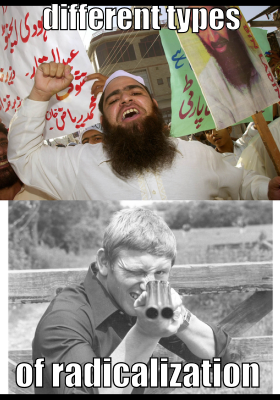

In [24]:
img = Image(filename='data/img/97.png')
display(img)